last update : 2021.06.24

#### Team Project 01 by 김동화, 최민혁
# 대륙별 코로나 사망률과 완치률

cf. 사망률 = 사망자수/확진자수, 완치률 = 완치자수/확진자수

## 목표
대륙별 코로나 사망률과 완치율의 시각화
#### 참조 링크
1) 코로나 실시간 상황판 [링크](https://coronaboard.kr/)  
2) 대륙별 나라 목록 [링크](https://ko.wikipedia.org/wiki/%EB%8C%80%EB%A5%99%EB%B3%84_%EB%82%98%EB%9D%BC_%EB%AA%A9%EB%A1%9D)

## 과정
- 주요 라이브러리 : `selenium` `bs4` `pandas`  

1. *1) 사이트*에서 국가별 코로나 사망률과 완치율 정보를 가져온다  
2. *2) 사이트*에서 국가 이름과 그 국가가 속한 대륙 이름을 가져온다.  
3. 국가별 사망률과 완치율, 국가가 속한 대륙 이름을 DataFrame으로 묶는다.  
4. 대륙별로 평균 사망률과 완치율의 평균을 구한다.  
5. 시각화한다.

## 결과

result.png![result.png](./result.png)




## 해석 및 향후 개선 사항
- 치명률에 비해 완치율의 분산이 크기 때문에 대륙에 따라서 완치율이 달라질 수 있다고 말할 수 있다.  
- 치명률과 완치율의 양상이 비슷하지 하지 않은 것으로 보았을 때 대륙별로 백신 보급, 의료환경 등 인위적이고 대륙마다 독립적인 요소들에 영향을 받았을 것으로 예상해볼 수 있다.  
- 전세계 백신 보급 현황 [링크](https://www.bbc.com/korean/features-56066227) 을 보았을 때 유럽 국가와 북아메리카의 보급률이 다른 국가에 비해 높은 것으로 확인되었다. 그럼에도 불구하고 완치율에 차이가 나는 것은 유럽에 비해 북아메리카의 의료 시설에 대한 접근성 등과 같은 대륙적 요소들의 영향을 끼쳤다고 생각해볼 수 있다.  
- 의료 후진국을 많이 포함하고 있는 아프리카 대륙의 치명률이 높을 것으로 예상하였지만, 다른 대륙들과 비슷한 수준의 치명률과 완치률을 가진 것으로 보아 인간의 면역체계와 백신 보급 등과 같은 국제적인 협조가 잘 작동하고 있다고 생각할 수 있다.   
- 사망률과 완치율은 서로 음의 상관관계를 가질 것으로 예상하였지만 분석해본 결과 그렇지는 않았다.  

### 1. 국가별 코로나 사망률, 완치율 
임동조 강사님 unit08_corona_01_today 파일 참고


In [3]:
from IPython.display import display, Image 
import os, warnings
import re
warnings.filterwarnings(action= 'ignore')

In [4]:
# 필수
from selenium import webdriver 
from bs4 import BeautifulSoup
import time

from selenium.webdriver import ActionChains
import pandas as pd
import matplotlib.pyplot as plt

from urllib.request import urlopen
import seaborn as sns

#### 1) 웹 드라이버 객체 할당 및 크롤링할 웹 페이지 띄우기

In [3]:
driver = webdriver.Chrome("../chromedriver")
driver

<selenium.webdriver.chrome.webdriver.WebDriver (session="5b9d730f313924f031b9c8d64b9ea474")>

In [4]:
corona_url = 'https://coronaboard.kr/'
driver.get(corona_url)

In [5]:
# 더보기 버튼 끝까지 누르기
xpath_btn = '//*[@id="show-more"]'
cnt = 0
while True:
    try :
        sel_btn = driver.find_element_by_xpath(xpath_btn)
        sel_btn.click()
        cnt += 1
    except :
        print("더보기 버튼을 %d번 눌렀습니다."%cnt)
        break

더보기 버튼을 2번 눌렀습니다.


#### 2) 웹 페이지 html 가져오기

In [6]:
page = driver.page_source
soup = BeautifulSoup(page, 'html.parser')
soup.title

<title>코로나19(COVID-19) 실시간 상황판</title>

#### 3) 원하는 정보 가져오기
- 전체 테이블 지정

In [7]:
table = soup.select("tbody > tr")
table[0] # index : 0~220

<tr class="google-visualization-table-tr-even"><td class="google-visualization-table-td google-visualization-table-seq">1</td><td class="google-visualization-table-td" colspan="1"><a href="https://coronaboard.com" target="_blank">미국🇺🇸</a></td><td class="google-visualization-table-type-number google-visualization-table-td" colspan="1">34,434,803<br/><span class="red diff">(+14,822)</span></td><td class="google-visualization-table-type-number google-visualization-table-td" colspan="1">617,875<br/><span class="red diff">(+392)</span></td><td class="google-visualization-table-type-number google-visualization-table-td" colspan="1">28,817,134<br/><span class="green diff">(+48,726)</span></td><td class="google-visualization-table-type-number google-visualization-table-td" colspan="1">1.8</td><td class="google-visualization-table-type-number google-visualization-table-td" colspan="1">83.7</td><td class="google-visualization-table-type-number google-visualization-table-td" colspan="1">104,032</

#### 3-1) 한 개의 국가만 가져오기 [test]
- 국가  
<U>이름에 링크가 있는 국가</U>(예.미국)와 <U>없는 국가</U>(예.인도)의 html 구성이 달라서 BeautifulSoup으로 동일한 항목을 뽑아내기 어려웠다. selenium의 xpath을 이용해서 찾았다. 

In [8]:
# selenium
sel_country = driver.find_elements_by_xpath('//*[@id="country-table"]/div/div/table/tbody/tr/td[2]') 
sel_country[0].text # index : 0~220 

'미국🇺🇸'

In [9]:
# BeautifulSoup
america = table[0]
print(america.a.text)

india = table[1]
print(india.find_all("td",class_="google-visualization-table-td")[1].text)

미국🇺🇸
인도🇮🇳


- 확진자, 사망자, 완치자, 치명률, 완치률, 발생률  
cf. 발생률 = 100만명당 발생률 (=확진자/인구수*1,000,000)

In [11]:
one = table[0]
num_tag = one.find_all("td", class_="google-visualization-table-type-number google-visualization-table-td")
print(num_tag[0].text) # 확진자
print(num_tag[1].text) # 사망자
print(num_tag[2].text) # 완치자
print(num_tag[3].text) # 치명률
print(num_tag[4].text) # 완치률
print(num_tag[5].text) # 발생률


34,434,803(+14,822)
617,875(+392)
28,817,134(+48,726)
1.8
83.7
104,032


#### 3-2) 모든 국가 가져오기
221개국까지 수집이 가능하지만, 치명률 정보가 나와있지 않은 국가가 있기 때문에 200개국까지만 정보를 받아온다.

In [12]:
table = soup.select("tbody > tr")

all_data = []
for n in range(200) : # 221까지 가능하지만 
    row_data = []
    
    # 국가
    sel_country = driver.find_elements_by_xpath('//*[@id="country-table"]/div/div/table/tbody/tr/td[2]') 
    row_data.append(sel_country[n].text) 
    
    # 확진자, 사망자, 완치자, 치명률, 완치률, 발생률
    one = table[n]
    num_tag = one.find_all("td", class_="google-visualization-table-type-number google-visualization-table-td")
    for i in range(6): 
        row_data.append(num_tag[i].text) 
    
    all_data.append(row_data)
    
all_data

[['미국🇺🇸',
  '34,434,803(+14,822)',
  '617,875(+392)',
  '28,817,134(+48,726)',
  '1.8',
  '83.7',
  '104,032'],
 ['인도🇮🇳',
  '30,028,709(+26,018)',
  '390,691(+1,030)',
  '28,994,855(+44,129)',
  '1.3',
  '96.6',
  '21,760'],
 ['브라질🇧🇷',
  '18,056,639(+86,833)',
  '504,897(+2,080)',
  '16,388,847(+100,455)',
  '2.8',
  '90.8',
  '84,949'],
 ['프랑스🇫🇷',
  '5,760,002(+2,204)',
  '110,829(+51)',
  '5,575,086(+8,692)',
  '1.9',
  '96.8',
  '88,244'],
 ['터키🇹🇷',
  '5,381,736(+6,143)',
  '49,293(+57)',
  '5,242,945(+5,214)',
  '0.9',
  '97.4',
  '63,811'],
 ['러시아🇷🇺', '5,350,919', '130,347', '4,889,450', '2.4', '91.4', '36,667'],
 ['영국🇬🇧',
  '4,651,988(+11,481)',
  '128,008(+27)',
  '4,306,482(+2,486)',
  '2.8',
  '92.6',
  '68,526'],
 ['아르헨티나🇦🇷',
  '4,298,782(+21,387)',
  '90,281(+791)',
  '3,928,389(+17,554)',
  '2.1',
  '91.4',
  '95,115'],
 ['이탈리아🇮🇹',
  '4,254,294(+834)',
  '127,322(+31)',
  '4,054,008(+4,692)',
  '3.0',
  '95.3',
  '70,363'],
 ['콜롬비아🇨🇴',
  '3,997,021(+28,616)',
  '101,302(+72

#### 4) DataFrame으로 만들어 csv 파일로 내보내기
- 파일명 : *corona_today.csv* (`f_name1` 객체에 저장)

In [13]:
f_name1 = 'corona_today.csv'
col_name = ["국가","확진자","사망자","완치자","치명(%)","완치(%)","발생률"]
dict_dat = pd.DataFrame(all_data, columns=col_name)
dict_dat.to_csv(f_name1, index=False)
dict_dat

,국가,확진자,사망자,완치자,치명(%),완치(%),발생률
0,미국🇺🇸,"34,434,803(+14,822)","617,875(+392)","28,817,134(+48,726)",1.8,83.7,"104,032"
1,인도🇮🇳,"30,028,709(+26,018)","390,691(+1,030)","28,994,855(+44,129)",1.3,96.6,"21,760"
2,브라질🇧🇷,"18,056,639(+86,833)","504,897(+2,080)","16,388,847(+100,455)",2.8,90.8,"84,949"
3,프랑스🇫🇷,"5,760,002(+2,204)","110,829(+51)","5,575,086(+8,692)",1.9,96.8,"88,244"
4,터키🇹🇷,"5,381,736(+6,143)","49,293(+57)","5,242,945(+5,214)",0.9,97.4,"63,811"
...,...,...,...,...,...,...,...
195,생바르텔레미🇧🇱,"1,005",1,462,0.1,46.0,"101,752"
196,페로 제도🇫🇴,769(+1),1,755,0.1,98.2,"15,738"
197,케이맨 제도🇰🇾,609,2,588(+1),0.3,96.6,"9,266"
198,탄자니아🇹🇿,509,21,183,4.1,36.0,9


### 2. 국가와 대륙
`BeautifulSoup`을 이용하여 위키백과의 대륙별 국가 목록을 수집하였습니다. 모든 국가의 목록을 가져와 그 국가가 속한 대륙을 수작업으로 추가하였습니다.
- 파일명 : *wiki.csv* (`f_name2` 객체에 저장)

In [30]:
url = "https://ko.wikipedia.org/wiki/%EB%8C%80%EB%A5%99%EB%B3%84_%EB%82%98%EB%9D%BC_%EB%AA%A9%EB%A1%9D"
page = urlopen(url)
soup = BeautifulSoup(page, 'html.parser')

In [32]:
name=soup.select('div.mw-parser-output>ul>li>a')
name_list = []
for one in name:
    name_list.append(one.text)

###  3. 국가별 사망률, 완치률, 대륙 정보를 DataFrame으로 묶기
#### 1) 국가별 사망률, 완치율 정보 불러오기
1.-4)에서 파일을 객체 `f_name1` 이름으로 저장

In [14]:
# f_name1 = 'corona_today.csv'
data1 = pd.read_csv(f_name1)
data1

,국가,확진자,사망자,완치자,치명(%),완치(%),발생률
0,미국🇺🇸,"34,434,803(+14,822)","617,875(+392)","28,817,134(+48,726)",1.8,83.7,"104,032"
1,인도🇮🇳,"30,028,709(+26,018)","390,691(+1,030)","28,994,855(+44,129)",1.3,96.6,"21,760"
2,브라질🇧🇷,"18,056,639(+86,833)","504,897(+2,080)","16,388,847(+100,455)",2.8,90.8,"84,949"
3,프랑스🇫🇷,"5,760,002(+2,204)","110,829(+51)","5,575,086(+8,692)",1.9,96.8,"88,244"
4,터키🇹🇷,"5,381,736(+6,143)","49,293(+57)","5,242,945(+5,214)",0.9,97.4,"63,811"
...,...,...,...,...,...,...,...
195,생바르텔레미🇧🇱,"1,005",1,462,0.1,46.0,"101,752"
196,페로 제도🇫🇴,769(+1),1,755,0.1,98.2,"15,738"
197,케이맨 제도🇰🇾,609,2,588(+1),0.3,96.6,"9,266"
198,탄자니아🇹🇿,509,21,183,4.1,36.0,9


#### 2) 국가별 대륙 정보 불러오기
- 2-x)에서 파일을 객체 `f_name2` 이름으로 저장

In [17]:
# f_name2 = 'wiki.csv'
data2 = pd.read_csv(f_name2)
data2

,국가,대륙
0,캐나다,북아메리카
1,미국,북아메리카
2,아르헨티나,남아메리카
3,바베이도스,북아메리카
4,버뮤다,남아메리카
...,...,...
221,슬로바키아,유럽
222,산마리노,유럽
223,우크라이나,유럽
224,바티칸 시국,유럽


#### 3) 코로나 실시간 상황판의 국가 순으로 대륙 정보 가져오기
- print되는 index와 국가 이름은 코로나 실시간 상황판에는 있지만, 위키백과에는 나와있지 않은 국가이다.
- 3-1) 과정을 통해 print된 국가들의 대륙 정보를 찾아서 `f_name2` 파일(from.위키백과)에 추가적으로 작성하면 해결 가능하다. 

In [18]:
country = data1["국가"]
contin = data2["대륙"]

result = []
for i, one in enumerate(country) :
    try :
        idx = data2.index[data2["국가"]==one[:-2]][0]
        result.append(contin[idx])
    except :
        print(i, one[:-2])
        result.append("그 외")

result

150 콩고공화국
152 퀴라소
153 마르티니크
157 아루바
163 중앙아프리카 공화국
164 예멘
174 지브롤터
177 기니비사우
181 신트마르턴
184 터크스 케이커스 제도
185 상투메 프린시페
188 세인트마틴 섬
192 카리브 네덜란드
193 맨섬
195 생바르텔레미
196 페로 제도
197 케이맨 제도
198 탄자니아
199 왈리스 퓌티나


['북아메리카',
 '아시아',
 '남아메리카',
 '유럽',
 '아시아',
 '아시아',
 '유럽',
 '남아메리카',
 '유럽',
 '남아메리카',
 '유럽',
 '유럽',
 '아시아',
 '유럽',
 '북아메리카',
 '유럽',
 '남아메리카',
 '아시아',
 '아프리카',
 '유럽',
 '유럽',
 '남아메리카',
 '북아메리카',
 '아시아',
 '아시아',
 '유럽',
 '유럽',
 '유럽',
 '아시아',
 '유럽',
 '아시아',
 '아시아',
 '유럽',
 '아시아',
 '아시아',
 '유럽',
 '아시아',
 '유럽',
 '유럽',
 '아시아',
 '아시아',
 '아시아',
 '아프리카',
 '아시아',
 '남아메리카',
 '남아메리카',
 '유럽',
 '유럽',
 '아시아',
 '유럽',
 '남아메리카',
 '북아메리카',
 '유럽',
 '아프리카',
 '아시아',
 '유럽',
 '남아메리카',
 '북아메리카',
 '아시아',
 '아시아',
 '북아메리카',
 '아시아',
 '유럽',
 '북아메리카',
 '유럽',
 '아시아',
 '아프리카',
 '유럽',
 '아시아',
 '남아메리카',
 '유럽',
 '유럽',
 '남아메리카',
 '아시아',
 '아시아',
 '아시아',
 '아시아',
 '아시아',
 '유럽',
 '아프리카',
 '아프리카',
 '북아메리카',
 '아프리카',
 '유럽',
 '아시아',
 '아시아',
 '유럽',
 '아시아',
 '아프리카',
 '유럽',
 '유럽',
 '유럽',
 '아시아',
 '아시아',
 '유럽',
 '아시아',
 '아시아',
 '유럽',
 '아프리카',
 '유럽',
 '아시아',
 '아프리카',
 '남아메리카',
 '아프리카',
 '아시아',
 '아프리카',
 '아프리카',
 '아시아',
 '유럽',
 '아프리카',
 '아시아',
 '북아메리카',
 '아프리카',
 '아시아',
 '아프리카',
 '아프리카',
 '아프리카',
 '아프리카',
 '아프리카',
 '아프리카',
 '아프리카',
 '아프리

#### 3-1) 오류로 나온  국가들 대륙 정보 csv 파일에 추가하기
*skip*

#### 4) 대륙 정보 추가해서 새로운 csv 파일로 내보내기 
- 파일명 : *corona_total.csv* (`f_name3` 객체로 저장)


In [19]:
f_name3 = "corona_total.csv"
data1["대륙"]=result
data1.to_csv(f_name3, index=False)

### 4. 대륙별로 사망률과 완치율의 평균 구하기

#### 1) 전체 데이터 불러오기
- 3.-4)에서 파일을 객체 `f_name3` 이름으로 저장

In [6]:
f_name3 = "corona_total.csv"
data_all = pd.read_csv(f_name3)
data_all

,국가,확진자,사망자,완치자,치명(%),완치(%),발생률,대륙
0,미국🇺🇸,"34,434,803(+14,822)","617,875(+392)","28,817,134(+48,726)",1.8,83.7,"104,032",북아메리카
1,인도🇮🇳,"30,028,709(+26,018)","390,691(+1,030)","28,994,855(+44,129)",1.3,96.6,"21,760",아시아
2,브라질🇧🇷,"18,056,639(+86,833)","504,897(+2,080)","16,388,847(+100,455)",2.8,90.8,"84,949",남아메리카
3,프랑스🇫🇷,"5,760,002(+2,204)","110,829(+51)","5,575,086(+8,692)",1.9,96.8,"88,244",유럽
4,터키🇹🇷,"5,381,736(+6,143)","49,293(+57)","5,242,945(+5,214)",0.9,97.4,"63,811",아시아
...,...,...,...,...,...,...,...,...
195,생바르텔레미🇧🇱,"1,005",1,462,0.1,46.0,"101,752",그 외
196,페로 제도🇫🇴,769(+1),1,755,0.1,98.2,"15,738",그 외
197,케이맨 제도🇰🇾,609,2,588(+1),0.3,96.6,"9,266",그 외
198,탄자니아🇹🇿,509,21,183,4.1,36.0,9,그 외


#### 2) 대륙별로 그룹화하여 평균 구하기

In [7]:
grouped = data_all.groupby("대륙")
grp_mean = grouped.mean()
grp_mean

,치명(%),완치(%)
대륙,,
그 외,1.941667,75.908333
남아메리카,2.980000,86.242857
북아메리카,2.288889,84.750000
아시아,1.593878,89.681633
아프리카,2.091489,86.651064
오세아니아,1.350000,79.550000
유럽,1.988372,94.482927


### 5. 시각화
#### 1) matplotlib 한글 패치

In [20]:
from matplotlib import font_manager, rc
import platform

In [21]:
path = "C:/Windows/Fonts/malgun.ttf" 
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name) 
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic') 
else:
    print("Unknown System") 
    matplotlib.rcParams['axes.unicode_minus'] = False

#### 2) 대륙별 치명률과 완치률 plot

In [22]:
x = grp_mean.index
y1 = grp_mean["치명(%)"]
y2 = grp_mean["완치(%)"]

(70.0, 100.0)

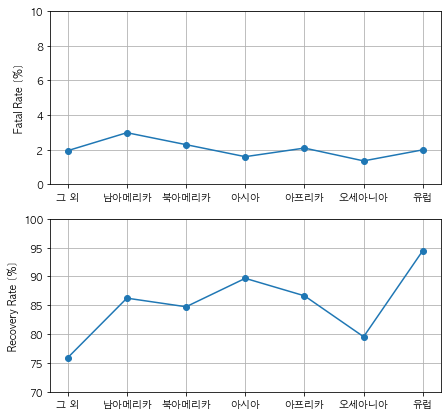

In [27]:
fig = plt.figure(figsize=(7,7))

ax1 = fig.add_subplot(211)
ax1.plot(x,y1, 'o-')
ax1.set_ylabel("Fatal Rate [%]")
ax1.grid()
ax1.set_ylim(0,10)

ax2 = fig.add_subplot(212)
ax2.plot(x,y2, 'o-')
ax2.set_ylabel("Recovery Rate [%]")
ax2.grid()
ax2.set_ylim(70, 100)

#### 3)  상관관계
- 예상 : 완치률이 높을수록 사망률은 낮게 나오지 않을까하여 음의 상관관계를 예상
- 결과 : 치명률과 완치율은 음의 상관관계를 가지지는 않는다.

In [25]:
grp_mean.corr()

,치명(%),완치(%)
치명(%),1.000000,0.170052
완치(%),0.170052,1.000000


#### 4) 통계치
- 시각화 결과를 통해서 완치율의 분포가 치명률보다 더 고르게 나타나는 것을 확인할 수 있었다. 데이터의 통계치를 확인해본 결과 완치율의 분산이 치명률보다 약 11배 정도 높았다. 따라서 대륙에 따라서 완치율이 달라질 수 있다고 이야기할 수 있겠다.

In [28]:
grp_mean.describe()

,치명(%),완치(%)
count,7.000000,7.000000
mean,2.033471,85.323831
std,0.522073,6.161759
min,1.350000,75.908333
25%,1.767772,82.150000
50%,1.988372,86.242857
75%,2.190189,88.166348
max,2.980000,94.482927
